In [5]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
vendor_df_w_out = pd.read_csv('./task1-result_w_out.csv', sep=',', index_col=0)
vendor_df_wo_out = pd.read_csv('./task1-result_wo_out.csv', sep=',', index_col=0)

## Auxiliary functions

In [6]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Compute label

In [8]:
vendor_df_w_out.head()

,I,Iu,AvgValuePerOrder,IMaxMonthSales,IAvgMonthItems,IMaxMonthItems,Egeo
vendor_code,,,,,,,
1,778,60,132.596405,13847.005800,31.120000,77,0.342666
2,3950,196,149.269497,59851.672722,197.500000,433,0.342791
3,3051,203,155.098549,326004.683245,1017.000000,2119,0.408351
4,407,101,142.140184,34249.837706,203.500000,238,0.284356
5,13042,276,165.866942,239686.814082,767.176471,1300,0.415029


What defines a seller as big?  
Since we don't really have any precise metrics, for the pourpose of this analysis we will work with the statistical distribution of the features in our vendor dataset.  


In [7]:
tmp_df = vendor_df_w_out.copy().drop(columns=["Iu"])
tmp_df["label"] = "small_seller"

for l, c in tmp_df.iteritems():
    if(l == "label"):
        continue
    tmp_df.loc[tmp_df[l] > tmp_df[l].quantile(0.90), "label"] = "big_seller"

tmp_df.groupby("label").size()

label
big_seller      22
small_seller    56
dtype: int64

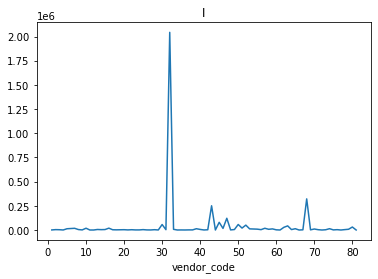

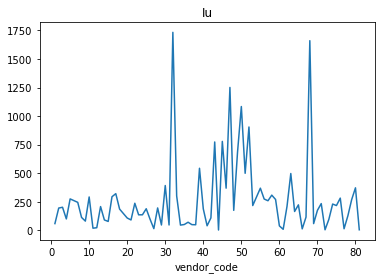

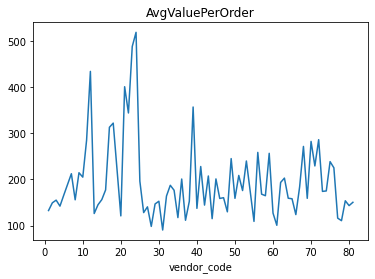

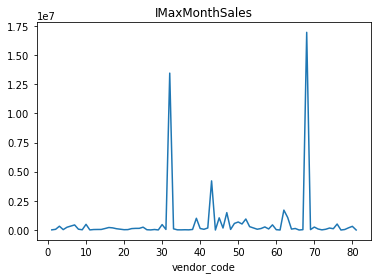

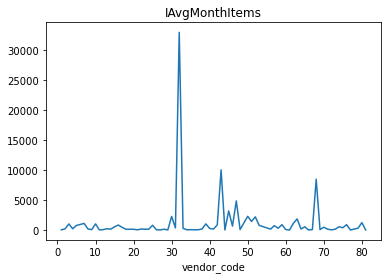

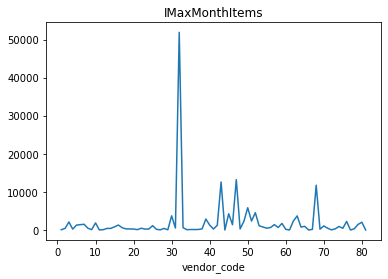

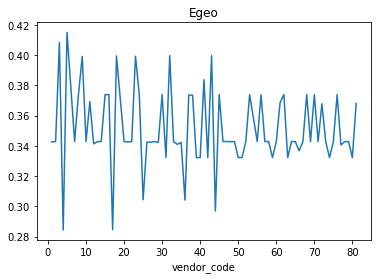

In [6]:
for c in vendor_df_w_out.columns:
    vendor_df_w_out[c].plot(title=c)
    plt.show()

In [7]:
dataset_df = tmp_df

## Decision trees

In [8]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
vendors_df = dataset_df.copy()
label = vendors_df.pop('label')
train_set, test_set, train_label, test_label = train_test_split(vendors_df, label, stratify =label, test_size=15)

In [16]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn import tree
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "max_features": range(1, vendors_df.shape[1] + 1),
              "criterion": ["gini"]}
#define the model
clf = tree.DecisionTreeClassifier(splitter='best')
#define the grid search
grid_search = GridSearchCV(clf, param_grid=param_dist,
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

print('Best setting parameters ', grid_search.cv_results_['params'][0])
#TODO: why the first element of the array?
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean and std of this setting  [0.87435897 0.88717949 0.87435897 ... 0.84102564 0.82435897 0.82435897] 0.05966705783702612


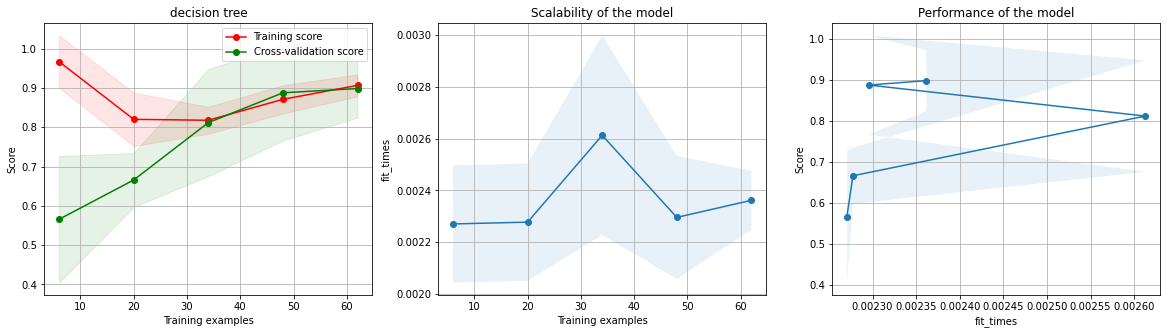

In [14]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=2, 
                                  max_features=1,
                                  min_samples_split=2, min_samples_leaf=1)

dt = dt.fit(train_set, train_label)
plot_learning_curve(dt, "decision tree", vendors_df, label)
plt.show()

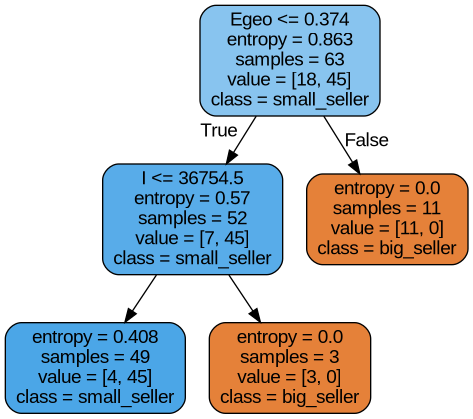

In [15]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [20]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [22]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['small_seller', 'big_seller']))

In [24]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.0023743311564127603
Score time  0.0020155111948649087
Test score  0.8412698412698413
Train score  0.9047619047619048


In [28]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision test set ', metrics.precision_score(test_label, test_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(test_label, test_pred_dt, average='weighted'))

Accuracy test set  0.8666666666666667
Precision test set  0.8871794871794872
Recall train set  0.8666666666666667


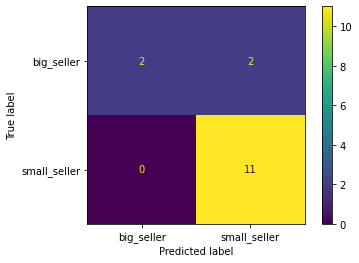

In [25]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

In [23]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

small_seller       1.00      0.50      0.67         4
  big_seller       0.85      1.00      0.92        11

    accuracy                           0.87        15
   macro avg       0.92      0.75      0.79        15
weighted avg       0.89      0.87      0.85        15



## Bayes classifier

In [80]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
vendors_df = dataset_df.copy()
label = vendors_df.pop('label')
train_set, test_set, train_label, test_label = train_test_split(vendors_df, label, stratify =label, test_size=15)

In [68]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [64]:
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

small_seller       0.58      0.70      0.64        10
  big_seller       0.87      0.80      0.83        25

    accuracy                           0.77        35
   macro avg       0.73      0.75      0.73        35
weighted avg       0.79      0.77      0.78        35



In [70]:
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_gnb))
print('Precision test set ', metrics.precision_score(test_label, test_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(test_label, test_pred_gnb, average='weighted'))

Accuracy test set  0.8
Precision test set  0.8428571428571429
Recall train set  0.8


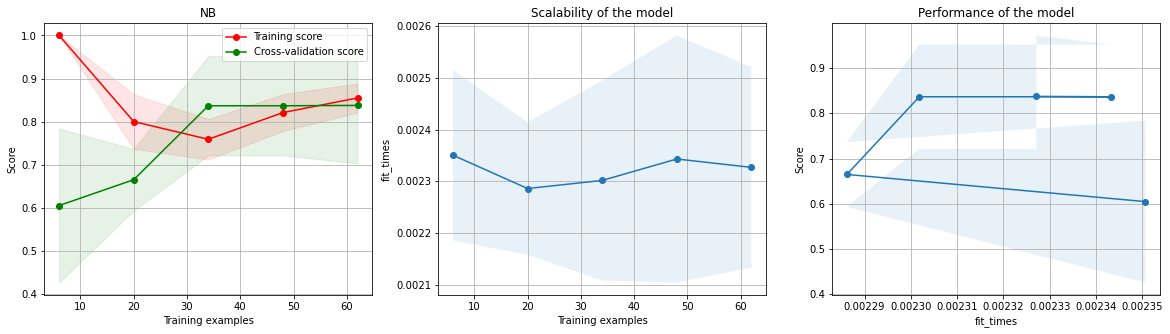

In [69]:
plot_learning_curve(gnb, "NB", vendors_df, label)
plt.show()

## Random forest

In [73]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [74]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [75]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

small_seller       0.50      0.50      0.50         4
  big_seller       0.82      0.82      0.82        11

    accuracy                           0.73        15
   macro avg       0.66      0.66      0.66        15
weighted avg       0.73      0.73      0.73        15



In [99]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 100
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30),
                   n_iter=100, n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd3a8f367c0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd3a8dd3370>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd3b04bd4c0>},
                   scoring=make_scorer(accuracy_score))

In [100]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 13, 'min_samples_split': 16}
Mean and std of this setting  0.6987179487179487 0.055883319788983


In [108]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=4,
                             max_depth=12, 
                             min_samples_split=30,
                             min_samples_leaf=29,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)
test_pred_rf = rf.predict(test_set)

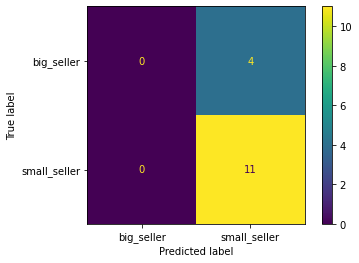

In [109]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(rf, test_set, test_label)
plt.show() 

In [101]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

small_seller       0.00      0.00      0.00         4
  big_seller       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15



/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
class_weights = {"small_seller": 0.90, "big_seller":0.10}
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=6, 
                             min_samples_split=32,
                             min_samples_leaf=10,
                             bootstrap=False,
                             class_weight= class_weights) 
rf = rf.fit(train_set, train_label)

In [122]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

small_seller       1.00      0.25      0.40         4
  big_seller       0.79      1.00      0.88        11

    accuracy                           0.80        15
   macro avg       0.89      0.62      0.64        15
weighted avg       0.84      0.80      0.75        15



## Classification with K-NN

In [132]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', metric='minkowski', p=2).fit(train_set, train_label)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

#compute the performance of the model
#TODO: try with PCA
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

small_seller       0.33      0.25      0.29         4
  big_seller       0.75      0.82      0.78        11

    accuracy                           0.67        15
   macro avg       0.54      0.53      0.53        15
weighted avg       0.64      0.67      0.65        15



## Classification with SVM

In [136]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)

#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

test_pred_svm = svm.predict(test_set)

#compute the performance of the model
report_scores(test_label,test_pred_svm)

              precision    recall  f1-score   support

small_seller       1.00      0.25      0.40         4
  big_seller       0.79      1.00      0.88        11

    accuracy                           0.80        15
   macro avg       0.89      0.62      0.64        15
weighted avg       0.84      0.80      0.75        15



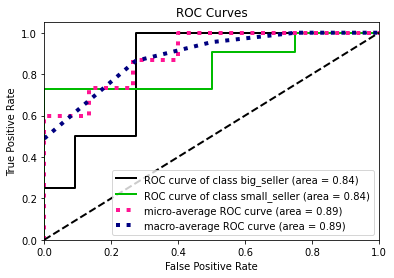

In [140]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm)
plt.show()

## Classification with rule based 

In [145]:
#we run a grid search to find the best configuration of parameters' values
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label, pos_class="big_seller")

GridSearchCV(estimator=<RIPPER(random_state=None, max_rules=None, max_total_conds=None, k=2, max_rule_conds=None, dl_allowance=64, prune_size=0.33, verbosity=0, n_discretize_bins=10)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [146]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

Best parameters setting  {'k': 1, 'prune_size': 0.5}


In [147]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
import wittgenstein as lw
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='label', pos_class="big_seller")

In [148]:
#in this case the model is a set of rules
ripper.ruleset_

<Ruleset [Egeo=0.37-0.42] V [I=30864-2043095] V [IMaxMonthSales=688145.1-16952382.26] V [AvgValuePerOrder=258.4-518.25]>

In [149]:
#evaluation of the performance of the classifier
from sklearn.metrics import precision_score, recall_score
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.8666666666666667
Precision  0.6666666666666666
Recall  1.0


In [150]:
#with rule based classifiers it is possible to extract the reasons for the prediction.
#only for the positive predictions
ripper.predict(test_set[:15], give_reasons=True)

([True,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  True],
 [[<Rule [Egeo=0.37-0.42]>],
  [],
  [<Rule [AvgValuePerOrder=258.4-518.25]>],
  [],
  [],
  [],
  [],
  [],
  [<Rule [I=30864-2043095]>, <Rule [IMaxMonthSales=688145.1-16952382.26]>],
  [],
  [],
  [],
  [<Rule [AvgValuePerOrder=258.4-518.25]>],
  [<Rule [AvgValuePerOrder=258.4-518.25]>],
  [<Rule [AvgValuePerOrder=258.4-518.25]>]])